In [ ]:

This code utilizes an ARIMA (Autoregressive Integrated Moving Average) model. The goal of this analysis is to examine the impact of the NY I-STOP law, a NY state law aimed at preventign prescription drug abuse implemented in 2013. This model will create a forecast of drug use based on data from before the law was enacted. Then, the forecasted pre-law drug use will be compared with the actual drug use after the law to examine the impact of the law on drug use.

In [18]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [50]:
# load the data frame

# If running in Google Colabs (Note: I switched from CoLabs to Jupyter Notebooks w/ CRC account because I ran out of RAM)
# Need to *Mount* the Google Drive first so it can actually access files!
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/MyDrive/Health_Hackathon_Catherine/chealy5_20241027222130.csv')

# Import data in chunks to save memory and make a dataframe
# chunksize = 500000
# data_chunks = []
# for chunk in pd.read_csv('/content/drive/MyDrive/Health_Hackathon_Catherine/chealy5_20241027222130.csv', chunksize=chunksize):
#     data_chunks.append(chunk)
# df = pd.concat(data_chunks, ignore_index=True)

# Note: I am loading things in chunks so that it saves memory and loads quicker
chunksize = 500000
data_chunks = []
for chunk in pd.read_csv('chealy5_20241027222130.csv', chunksize=chunksize):
    data_chunks.append(chunk)
df = pd.concat(data_chunks, ignore_index=True)

In [20]:
df.head()

,quantity,transaction_date,calc_base_wt_in_gm,dosage_unit,strength,buyer_zip,buyer_state,buyer_addl_co_info,drug_code,drug_name,mme_conversion_factor,measure
0,5,01/01/2006,7.567500,2500.0,0.0,13669,NY,KINNEY DRUGS #09,9193,HYDROCODONE,1.0,TAB
1,1,01/01/2006,2.270250,500.0,0.0,13021,NY,KINNEY DRUGS #62,9193,HYDROCODONE,1.0,TAB
2,1,01/01/2006,0.572708,NaN,NaN,11706,NY,NaN,9193,HYDROCODONE,1.0,ML
3,2,01/01/2006,1.145417,NaN,NaN,11414,NY,D/B/A CROSS BAY CHEMIST,9193,HYDROCODONE,1.0,ML
4,1,01/01/2006,0.572708,NaN,NaN,11355,NY,NaN,9193,HYDROCODONE,1.0,ML


In [21]:
# Formatting the timeseries

# I will convert the dates to the "datetime" format with to_datetime function. Example of the format: 01/01/2024 --> 2024-01-01
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%m/%d/%Y') 

# Make the index the transaction date. It should be a datetime index in equally spaced time intervals
df.set_index('transaction_date', inplace=True)

# Display the DataFrame to verify it looks reasonable
print(df)

                  quantity  calc_base_wt_in_gm  dosage_unit  strength  \
transaction_date                                                        
2006-01-01               5            7.567500       2500.0       0.0   
2006-01-01               1            2.270250        500.0       0.0   
2006-01-01               1            0.572708          NaN       NaN   
2006-01-01               2            1.145417          NaN       NaN   
2006-01-01               1            0.572708          NaN       NaN   
...                    ...                 ...          ...       ...   
2019-12-31               1            0.448250        100.0       NaN   
2019-12-31               1            0.448250        100.0       NaN   
2019-12-31               1            0.448250        100.0       NaN   
2019-12-31               1            0.448250        100.0       NaN   
2019-12-31               2            0.896500        200.0       NaN   

                  buyer_zip buyer_state       buye

In [22]:
# We will filter down to 6 main drugs that are the most commonly abused. 
# An historical pattern analysis published by Unick et al. in 2013 noted a certain few prescription opioids that are most commonly abused. 
#These drugs are fentanyl, oxycodone, hydrocodone, morphine, hydromorphone, and codeine.
included_drugs = ['FENTANYL','OXYCODONE','HYDROCODONE','MORPHINE','HYDROMORPHONE','CODEINE']

df = df[df['drug_name'].isin(included_drugs)]

df.head() # sanity check

,quantity,calc_base_wt_in_gm,dosage_unit,strength,buyer_zip,buyer_state,buyer_addl_co_info,drug_code,drug_name,mme_conversion_factor,measure
transaction_date,,,,,,,,,,,
2006-01-01,5,7.567500,2500.0,0.0,13669,NY,KINNEY DRUGS #09,9193,HYDROCODONE,1.0,TAB
2006-01-01,1,2.270250,500.0,0.0,13021,NY,KINNEY DRUGS #62,9193,HYDROCODONE,1.0,TAB
2006-01-01,1,0.572708,NaN,NaN,11706,NY,NaN,9193,HYDROCODONE,1.0,ML
2006-01-01,2,1.145417,NaN,NaN,11414,NY,D/B/A CROSS BAY CHEMIST,9193,HYDROCODONE,1.0,ML
2006-01-01,1,0.572708,NaN,NaN,11355,NY,NaN,9193,HYDROCODONE,1.0,ML


In [23]:
df.tail() # Another sanity check

,quantity,calc_base_wt_in_gm,dosage_unit,strength,buyer_zip,buyer_state,buyer_addl_co_info,drug_code,drug_name,mme_conversion_factor,measure
transaction_date,,,,,,,,,,,
2019-12-31,1,0.44825,100.0,NaN,10024,NY,NaN,9143,OXYCODONE,1.5,TAB
2019-12-31,1,0.44825,100.0,NaN,10461,NY,DBA: WALGREENS,9143,OXYCODONE,1.5,TAB
2019-12-31,1,0.44825,100.0,NaN,10458,NY,DBA: WALGREENS #10411,9143,OXYCODONE,1.5,TAB
2019-12-31,1,0.44825,100.0,NaN,10016,NY,NaN,9143,OXYCODONE,1.5,TAB
2019-12-31,2,0.89650,200.0,NaN,10010,NY,DBA: WALGREENS # 07675,9143,OXYCODONE,1.5,TAB


In [24]:
df.index # Index should be datetime format

DatetimeIndex(['2006-01-01', '2006-01-01', '2006-01-01', '2006-01-01',
               '2006-01-01', '2006-01-01', '2006-01-01', '2006-01-01',
               '2006-01-01', '2006-01-01',
               ...
               '2019-12-31', '2019-12-31', '2019-12-31', '2019-12-31',
               '2019-12-31', '2019-12-31', '2019-12-31', '2019-12-31',
               '2019-12-31', '2019-12-31'],
              dtype='datetime64[ns]', name='transaction_date', length=32266649, freq=None)

In [25]:
# This analysis would be ideal, but the data has a lot of NaN entries for dosage_unit & strength, so I cannot calculate this
# Calcualte the amount of drug in  milligrams of morphine equivalent
# Add mme as a column by multiplying dosage_unit * strength * conversion factor
# df['MME'] = df['dosage_unit'] * df['strength'] * df['mme_conversion_factor']
# Calcualte weight in grams based on drug

# Due to data limitations, we will have to use the amount of active ingredients and multiply by a conversion factor specific to the drug
# The following conversion factors are used based on this paper and CDC data: https://www.sciencedirect.com/science/article/pii/S0376871617302971?via%3Dihub#sec0015
# Note that it is multiplied by 1000 to go from grams to mg and the conversion factors align with those in the conversion_factor column
# conversion_factor = {
#     'FENTANYL':(1,000 * 2.4),
#     'OXYCODONE':(1000 * 1.5),
#     'HYDROCODONE':1000,
#     'MORPHINE':1000,
#     'HYDROMORPHONE':(1000 * 4),
#     'CODEINE':(1000 * .15)
# }
# df['conversion_factor'] = df['drug_name'].map(conversion_factor)
# df['conversion_factor'] = pd.to_numeric(df['conversion_factor'], errors='coerce')

# Miligrams of Morphiene Equivaluent (MME) should be this formula
df['MME'] = df['calc_base_wt_in_gm'] * df['mme_conversion_factor'] * 1000
df['MME'].head() # check that it worked

transaction_date
2006-01-01    7567.5000
2006-01-01    2270.2500
2006-01-01     572.7084
2006-01-01    1145.4169
2006-01-01     572.7084
Name: MME, dtype: float64

In [10]:
df.head() # Make sure MME was added

,quantity,calc_base_wt_in_gm,dosage_unit,strength,buyer_zip,buyer_state,buyer_addl_co_info,drug_code,drug_name,mme_conversion_factor,measure,MME
transaction_date,,,,,,,,,,,,
2006-01-01,5,7.567500,2500.0,0.0,13669,NY,KINNEY DRUGS #09,9193,HYDROCODONE,1.0,TAB,7567.5000
2006-01-01,1,2.270250,500.0,0.0,13021,NY,KINNEY DRUGS #62,9193,HYDROCODONE,1.0,TAB,2270.2500
2006-01-01,1,0.572708,NaN,NaN,11706,NY,NaN,9193,HYDROCODONE,1.0,ML,572.7084
2006-01-01,2,1.145417,NaN,NaN,11414,NY,D/B/A CROSS BAY CHEMIST,9193,HYDROCODONE,1.0,ML,1145.4169
2006-01-01,1,0.572708,NaN,NaN,11355,NY,NaN,9193,HYDROCODONE,1.0,ML,572.7084


In [26]:
df['MME'].min()
df['MME'].max()

np.float64(2368619000000.0)

In [12]:
# Make sure that most of the data is reasonable
print(df['MME'].isnull().sum())  # Check for NaNs  # 2 Nans
print(np.isinf(df['MME']).sum())  # check for inifinite vals: 0 inifinte values

# num_non_nan = df['MME'].count()
# print(num_non_nan) # count is 18643433

df['MME'].tail() 

2
0


transaction_date
2019-12-31     672.375
2019-12-31     672.375
2019-12-31     672.375
2019-12-31     672.375
2019-12-31    1344.750
Name: MME, dtype: float64

In [27]:
# Figure out the dates where the values are Nan so I can look for any abnormalities
nan_dates = df[df['MME'].isnull()].index

# Print the dates where 'MME' is NaN
print(nan_dates)

DatetimeIndex(['2010-01-04', '2010-01-13'], dtype='datetime64[ns]', name='transaction_date', freq=None)


In [28]:
quarterly_mme_full_timeline = df.resample('QE')['MME'].sum().reset_index() # Divide time periods into quarters. (4 quarters in a year)

In [29]:
print(quarterly_mme_full_timeline.head())
print(len(quarterly_mme_full_timeline))


  transaction_date           MME
0       2006-03-31  4.742183e+10
1       2006-06-30  5.186395e+10
2       2006-09-30  5.198185e+10
3       2006-12-31  5.281470e+10
4       2007-03-31  5.959838e+10
56


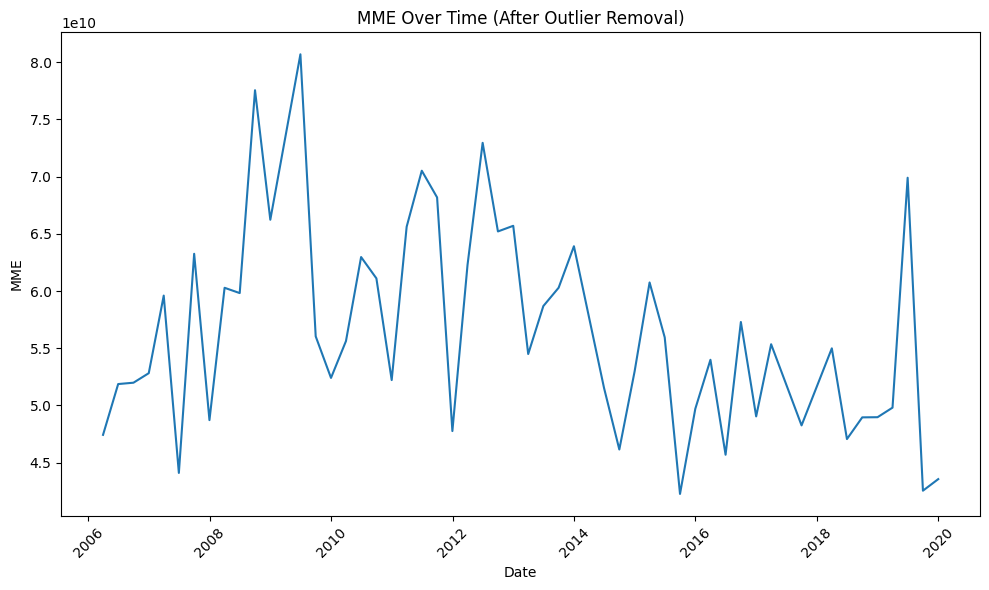

In [31]:
# Filter out the main outliers
# Calculate the first (Q1) and third (Q3) quartiles
Q1 = quarterly_mme_full_timeline['MME'].quantile(0.25)
Q3 = quarterly_mme_full_timeline['MME'].quantile(0.75)

# Calculate the Interquartile range (IQR)
IQR = Q3 - Q1

# make the bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove the major outliers
filtered_data = quarterly_mme_full_timeline[
    (quarterly_mme_full_timeline['MME'] >= lower_bound) & 
    (quarterly_mme_full_timeline['MME'] <= upper_bound)
]

# Plot the filtered data- This plot will have the total MME for the whole time period and will not be separated by drug type
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['transaction_date'], filtered_data['MME'])
plt.title('MME Over Time (After Outlier Removal)')
plt.xlabel('Date')
plt.ylabel('MME')
plt.xticks(rotation=45)  # rotate the x axis labels so they are readable
plt.tight_layout()  # Format/adjust so it all fits
plt.show()

In [17]:
df.head()

,quantity,calc_base_wt_in_gm,dosage_unit,strength,buyer_zip,buyer_state,buyer_addl_co_info,drug_code,drug_name,mme_conversion_factor,measure,MME
transaction_date,,,,,,,,,,,,
2006-01-01,5,7.567500,2500.0,0.0,13669,NY,KINNEY DRUGS #09,9193,HYDROCODONE,1.0,TAB,7567.5000
2006-01-01,1,2.270250,500.0,0.0,13021,NY,KINNEY DRUGS #62,9193,HYDROCODONE,1.0,TAB,2270.2500
2006-01-01,1,0.572708,NaN,NaN,11706,NY,NaN,9193,HYDROCODONE,1.0,ML,572.7084
2006-01-01,2,1.145417,NaN,NaN,11414,NY,D/B/A CROSS BAY CHEMIST,9193,HYDROCODONE,1.0,ML,1145.4169
2006-01-01,1,0.572708,NaN,NaN,11355,NY,NaN,9193,HYDROCODONE,1.0,ML,572.7084


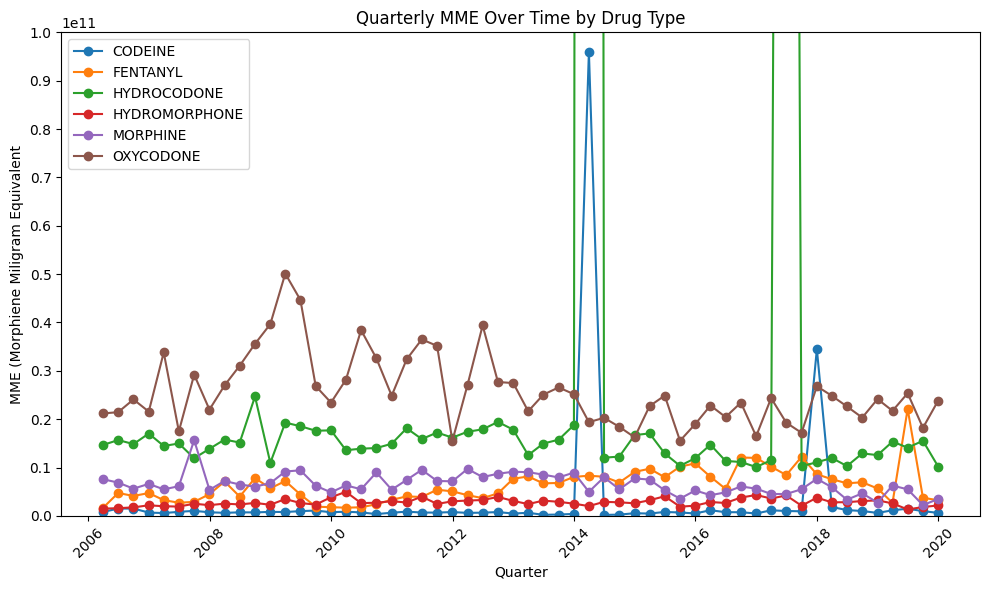

In [34]:
# Group into quarters and print out the trends for the entire time period range.

# Resample the data to get quarterly MME sums. They are grouped by the drug name for the 6 drugs
quarterly_mme_full_period = df.groupby('drug_name').resample('QE')['MME'].sum().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
for drug in quarterly_mme_full_period['drug_name'].unique():
    subset = quarterly_mme_full_period[quarterly_mme_full_period['drug_name'] == drug]
    plt.plot(subset['transaction_date'], subset['MME'], marker='o', label=drug)
# Formatting/labels
plt.title('Quarterly MME Over Time by Drug Type')
plt.xlabel('Quarter')
plt.ylabel('MME (Morphiene Miligram Equivalent')
plt.legend()
plt.xticks(rotation=45)
plt.ylim(0, 1e10)  # Set the y-axis limit from 0 to 1*10^19
plt.yticks(ticks=[i * 1e10 for i in range(0, 11)])
plt.tight_layout()
plt.show()

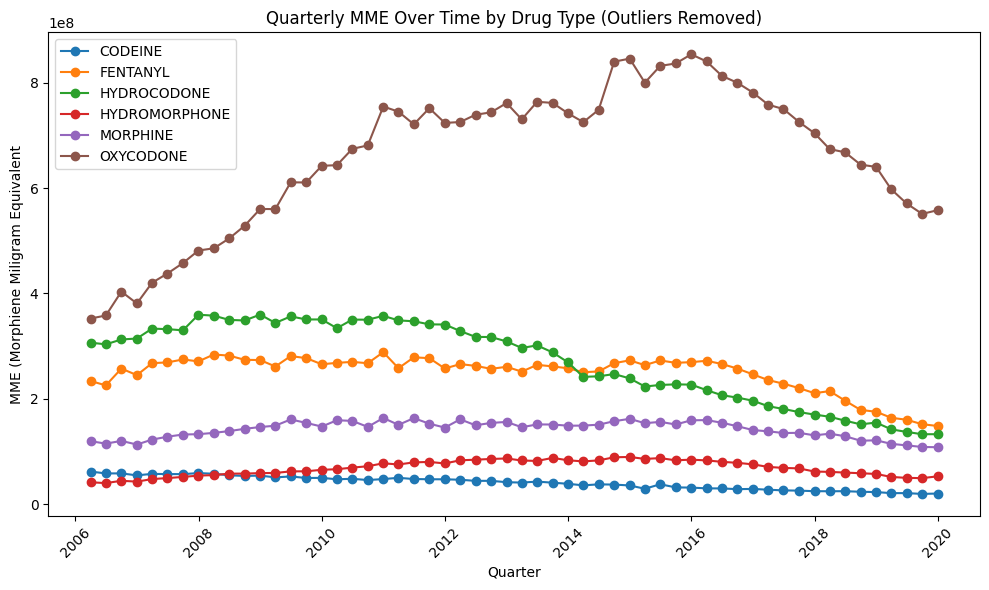

In [36]:
# Same but remove outliers (same method as earlier earlier)
#  calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['MME'].quantile(0.25)
Q3 = df['MME'].quantile(0.75)
IQR = Q3 - Q1

# make the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# actually filter out the outliers
df_filtered = df[(df['MME'] >= lower_bound) & (df['MME'] <= upper_bound)]

# resample it and plot it with each drug plotted separately
quarterly_mme_filtered = df_filtered.groupby('drug_name').resample('QE')['MME'].sum().reset_index()

# Make the plot!
plt.figure(figsize=(10, 6))
for drug in quarterly_mme_filtered['drug_name'].unique():
    subset = quarterly_mme_filtered[quarterly_mme_filtered['drug_name'] == drug]
    plt.plot(subset['transaction_date'], subset['MME'], marker='o', label=drug)

plt.title('Quarterly MME Over Time by Drug Type (Outliers Removed)')
plt.xlabel('Quarter')
plt.ylabel('MME (Morphiene Miligram Equivalent')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

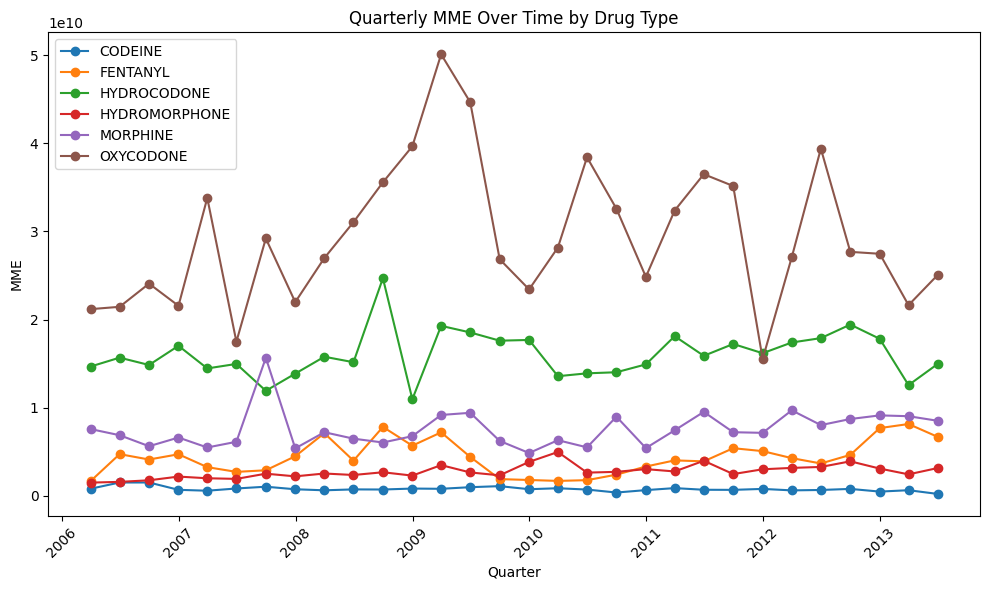

In [37]:
# Filter data by date. We will cutoff at the end of Q2 in 2013 because the law gets implemented in the next quarter.
# We only want the data before the I-STOP Law went into effect on August 27th, 2013. But I will cut off a little earlier so the 
# data for the final quarter is complete.
end_date = '2013-06-30'

# make sure the index is a datetime index for resampling
df_pre_2013 = df[(df.index < end_date)]

#resample it quarterly and group by drug type
quarterly_mme = df_pre_2013.groupby('drug_name').resample('QE')['MME'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
for drug in quarterly_mme['drug_name'].unique():
    subset = quarterly_mme[quarterly_mme['drug_name'] == drug]
    plt.plot(subset['transaction_date'], subset['MME'], marker='o', label=drug)

plt.title('Quarterly MME Over Time by Drug Type')
plt.xlabel('Quarter')
plt.ylabel('MME')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

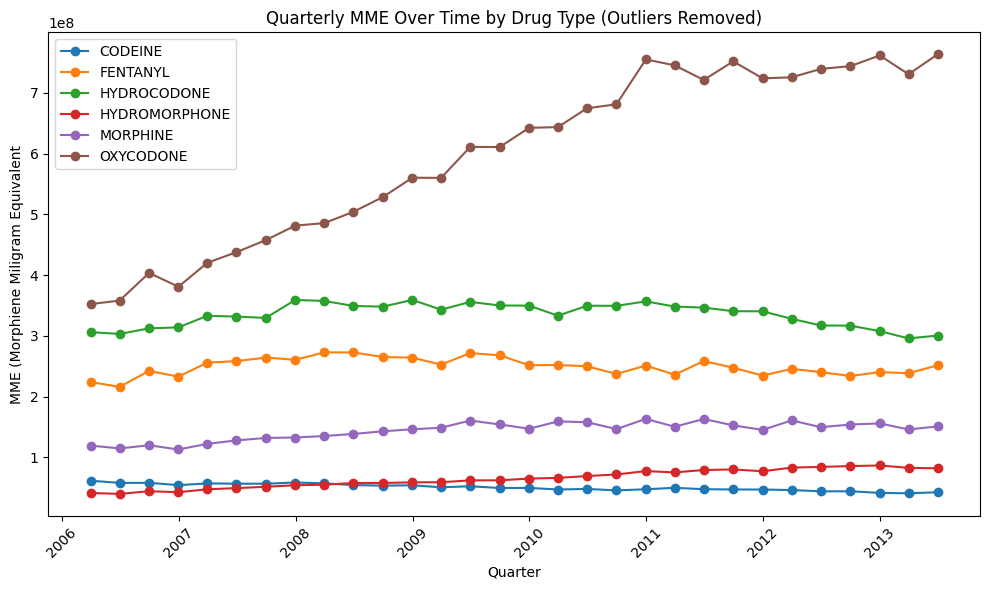

In [38]:
# Attempted outlier removal (Again, same strategy as before but now with the cutoff date at 2013):
# Filter data by date. We will cutoff at the end of Q2 in 2013.
end_date = '2013-06-30'

# Ensure the index is a datetime index for filtering
df_pre_2013 = df[df.index < end_date]

# Calculate Q1 and Q3 for MME so outliers are identified
Q1 = df_pre_2013['MME'].quantile(0.25)
Q3 = df_pre_2013['MME'].quantile(0.75)
IQR = Q3 - Q1

# create the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_pre_2013_filtered = df_pre_2013[(df_pre_2013['MME'] >= lower_bound) & (df_pre_2013['MME'] <= upper_bound)]

# Resample the data to get quarterly MME sums, grouping by drug_name
quarterly_mme = df_pre_2013_filtered.groupby('drug_name').resample('QE')['MME'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
for drug in quarterly_mme['drug_name'].unique():
    subset = quarterly_mme[quarterly_mme['drug_name'] == drug]
    plt.plot(subset['transaction_date'], subset['MME'], marker='o', label=drug)

plt.title('Quarterly MME Over Time by Drug Type (Outliers Removed)')
plt.xlabel('Quarter')
plt.ylabel('MME (Morphiene Miligram Equivalent')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
# Define the function that will Check for stationarity (stationarity is about having consistent patterns with consistent means, etc.)
def check_stationarity(time_series):
    result = adfuller(time_series) # use the augmented dickey-fuller test to check for stationarity
    return result[0], result[1]  # Return ADF Statistic and p-value

# Store results for each of the 6 drugs separately
results = []

# Loop through each of the 6 drug types checking the stationarity
for drug in quarterly_mme['drug_name'].unique():
    subset = quarterly_mme[quarterly_mme['drug_name'] == drug].copy()  # Create a copy to avoid warnings
    
    # Initially check if stationary
    print(f"Checking stationarity for {drug}:")
    adf_stat, p_value = check_stationarity(subset['MME'])
    
    results.append((drug, adf_stat, p_value, "Initial Check"))
    
    if p_value < 0.05:
        print(f"{drug} is stationary.")
    else: # If not stationary, apply the differencing
        print(f"{drug} is not stationary. Differencing is being applied.")
        
        # Apply differencing
        subset['differenced_MME'] = subset['MME'].diff()
        
        # After the differencing, see if stationary
        adf_stat_diff, p_value_diff = check_stationarity(subset['differenced_MME'].dropna())
        
        results.append((drug, adf_stat_diff, p_value_diff, "After Differencing"))
        
        if p_value_diff < 0.05: # Stationary after differencing
            print(f"{drug} is stationary after differencing.")
        else: # Not stationary after differencing
            print(f"{drug} is still not stationary after differencing.")

# Results printed here!
print("\nFinal ADF and p-values:")
for drug, adf_stat, p_value, check_type in results:
    print(f"{drug} - ADF Statistic: {adf_stat:.4f}, p-value: {p_value:.4f} ({check_type})")

# Results: All of them require differencing but are stationary after differencing

Checking stationarity for CODEINE:
CODEINE is not stationary. Differencing is being applied.
CODEINE is stationary after differencing.
Checking stationarity for FENTANYL:
FENTANYL is not stationary. Differencing is being applied.
FENTANYL is stationary after differencing.
Checking stationarity for HYDROCODONE:
HYDROCODONE is not stationary. Differencing is being applied.
HYDROCODONE is stationary after differencing.
Checking stationarity for HYDROMORPHONE:
HYDROMORPHONE is not stationary. Differencing is being applied.
HYDROMORPHONE is stationary after differencing.
Checking stationarity for MORPHINE:
MORPHINE is not stationary. Differencing is being applied.
MORPHINE is stationary after differencing.
Checking stationarity for OXYCODONE:
OXYCODONE is not stationary. Differencing is being applied.
OXYCODONE is stationary after differencing.

Final ADF and p-values:
CODEINE - ADF Statistic: -0.5815, p-value: 0.8751 (Initial Check)
CODEINE - ADF Statistic: -8.1779, p-value: 0.0000 (After 

In [ ]:
# Make sure date time is formatted
quarterly_mme['transaction_date'] = pd.to_datetime(quarterly_mme['transaction_date']) 
quarterly_mme.set_index('transaction_date', inplace=True)

# check time series for seasonality
plt.figure(figsize=(10, 6))
plt.plot(quarterly_mme['MME'], label='MME Time Series')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('MME')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Handle the NaN values by taking the previous value/forward-filling
df_filled = quarterly_mme.ffill()

# Decompose the time series 
decomposition = seasonal_decompose(df_filled['MME'], model='additive', period=4)

# Plot 
decomposition.plot()
plt.show()

In [ ]:
# # make a ACF plot (FOR ALL Drugs)
# # There are 31 quarters. Normally # of lags is about 20% of # of data points. So 6 lags would be good
# plt.figure(figsize=(12, 6))
# plot_acf(quarterly_mme['MME'], lags=6, ax=plt.gca())
# plt.title('ACF Plot') #Note: The ACF plot has issues
# plt.show()

# # make a PACF Plot (ALL DRUGS)
# plt.figure(figsize=(12, 6))
# plot_pacf(quarterly_mme['MME'], lags=6, ax=plt.gca())
# plt.title('PACF Plot')
# plt.show()

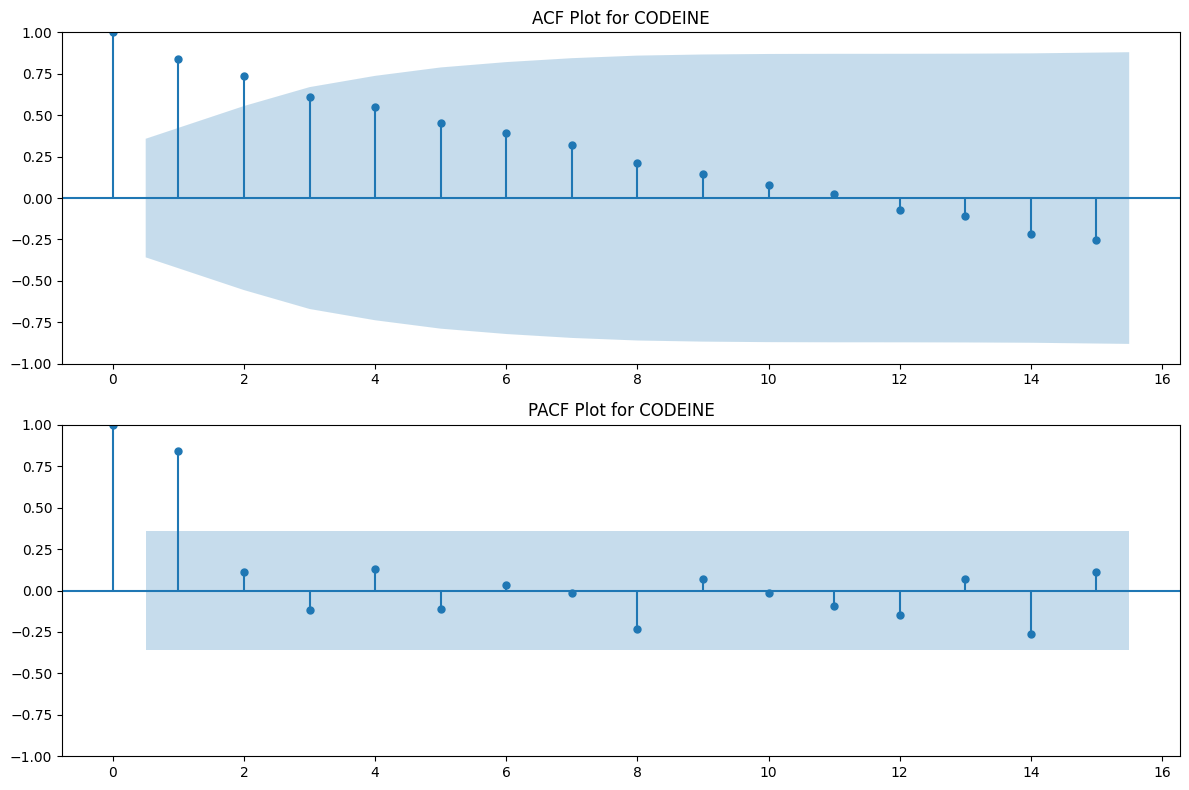

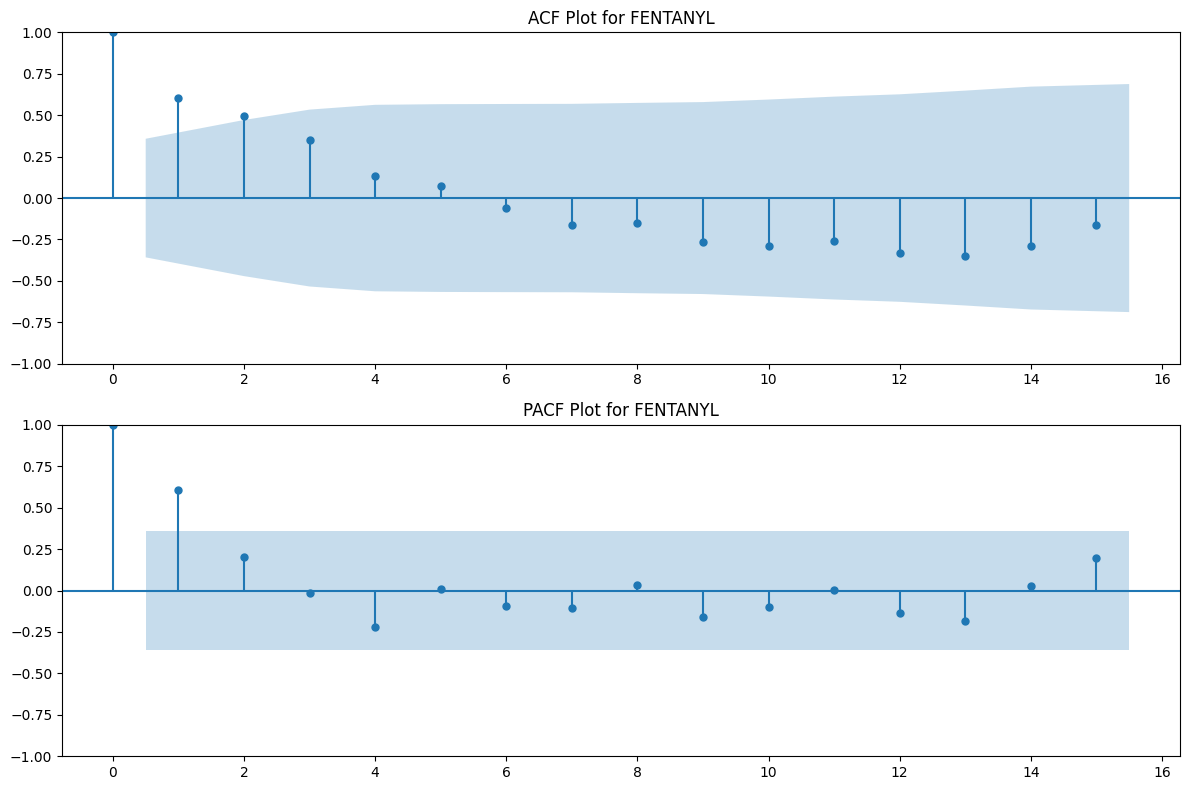

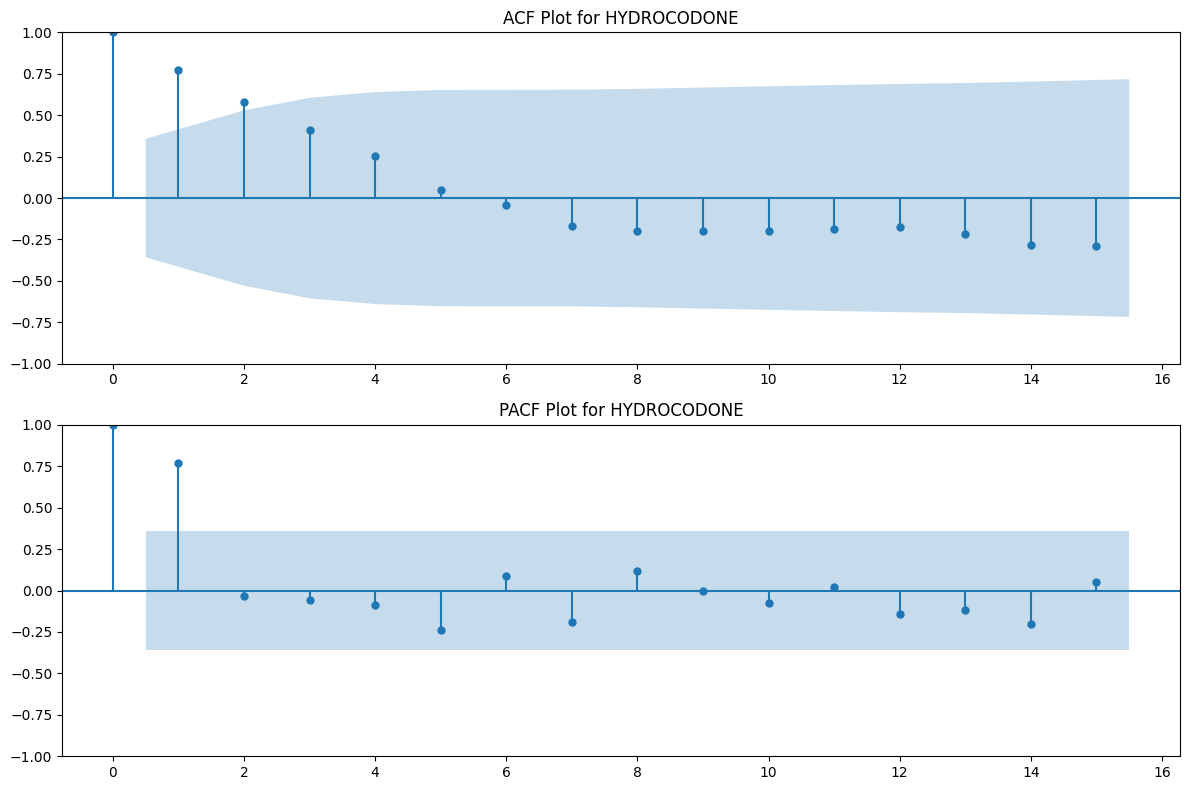

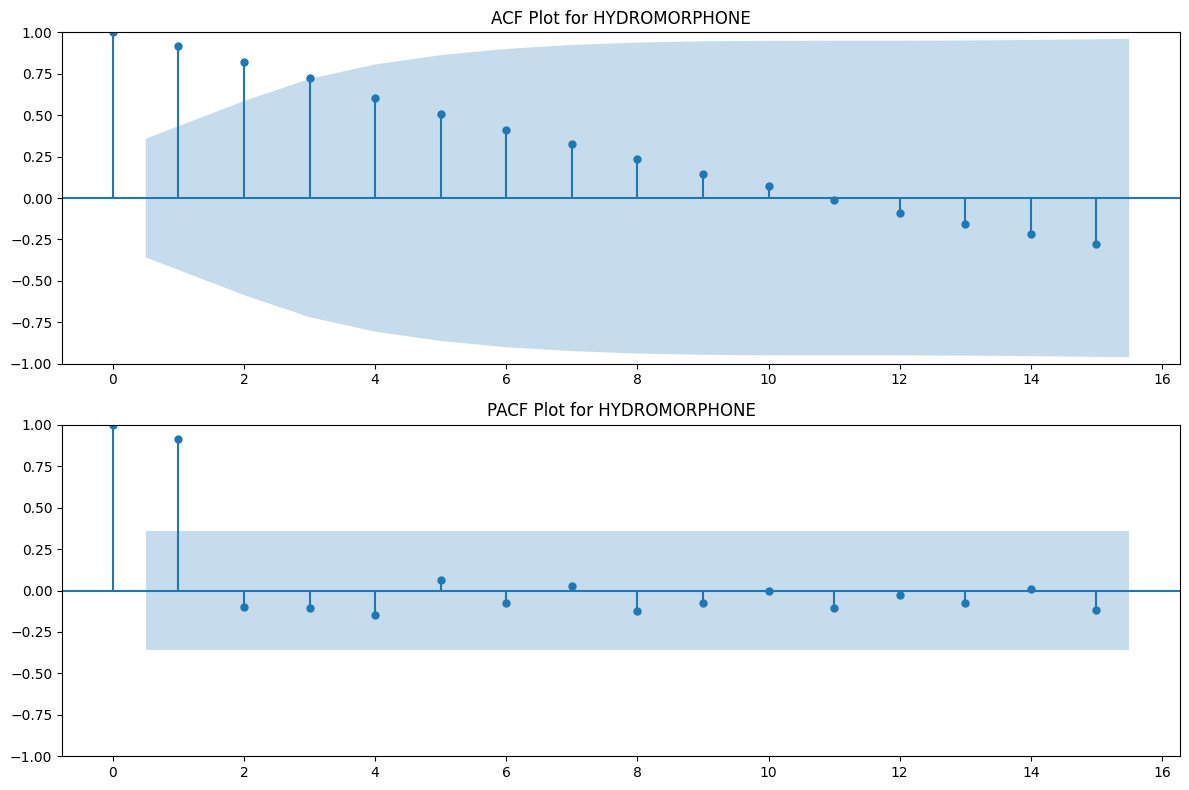

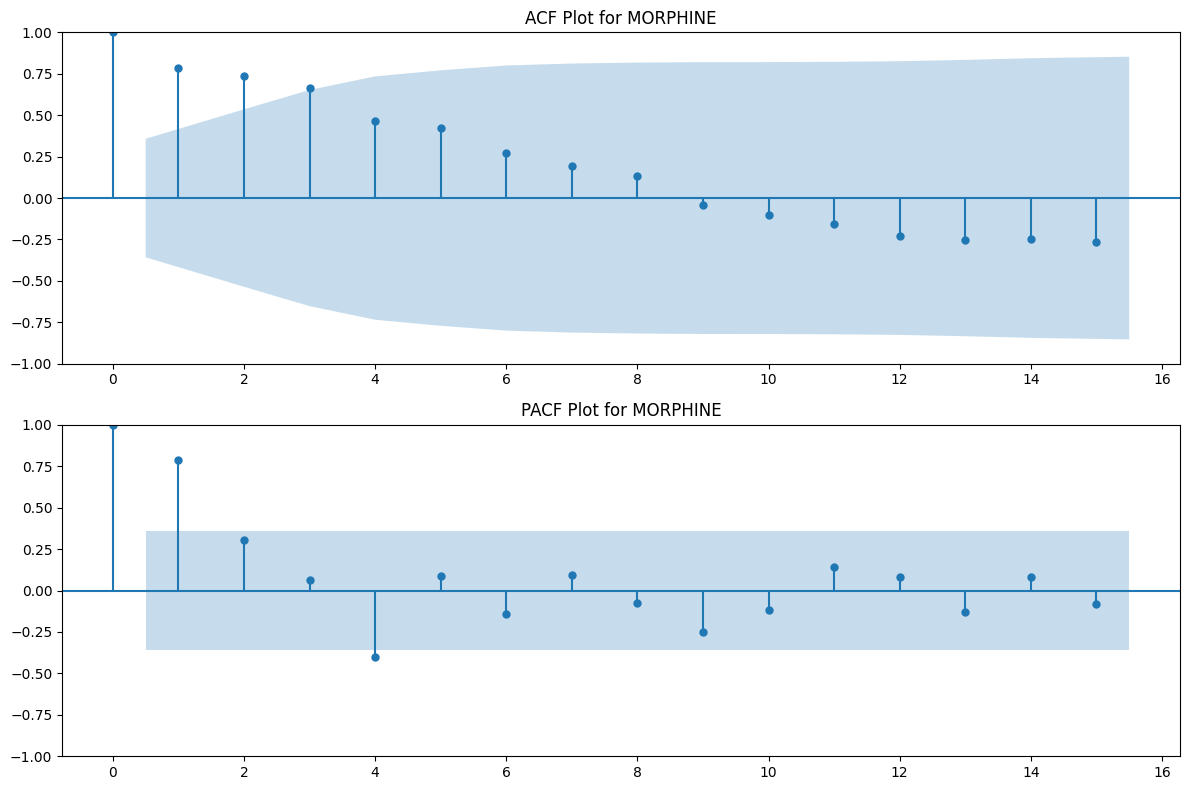

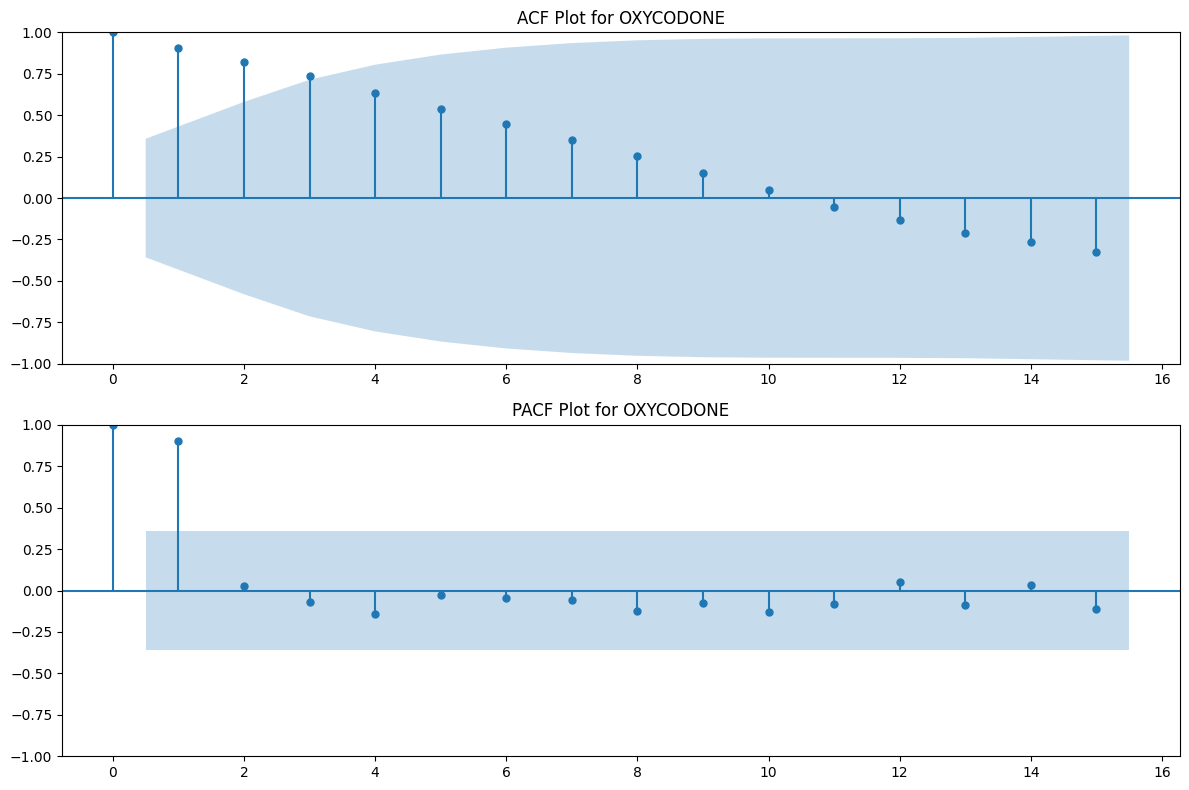

In [42]:
# MAKE SEPARATE PLOTS FOR EACH DRUG
# Get unique drug names
unique_drugs = quarterly_mme['drug_name'].unique()

# Loop through each drug to create ACF and PACF plots
for drug in unique_drugs:
    # Get the current drug
    drug_data = quarterly_mme[quarterly_mme['drug_name'] == drug]
    
    # check if empty
    if drug_data.empty:
        print(f"No data available for {drug}.")
        continue

    # Determine the number of lags
    num_lags = 15  # 15 was used because it is half the dataset

    # Create subplots for ACF and PACF
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    
    # plot ACF (Autocorrelation function)
    plot_acf(drug_data['MME'], lags=num_lags, ax=ax[0])
    ax[0].set_title(f'ACF Plot for {drug}')
    
    # plot PACF (Partial autocorrelation function)
    plot_pacf(drug_data['MME'], lags=num_lags, ax=ax[1])
    ax[1].set_title(f'PACF Plot for {drug}')
    
    # format it
    plt.tight_layout()
    plt.show()


In [43]:
# Reformat transaction date
# quarterly_mme['transaction_date'] = pd.to_datetime(quarterly_mme['transaction_date'])
# quarterly_mme.set_index('transaction_date', inplace=True)
quarterly_mme.head()

,drug_name,MME
transaction_date,,
2006-03-31,CODEINE,6.183866e+07
2006-06-30,CODEINE,5.819353e+07
2006-09-30,CODEINE,5.830078e+07
2006-12-31,CODEINE,5.455124e+07
2007-03-31,CODEINE,5.734855e+07


In [ ]:
# DO NOT DELETE THIS CELL! It helps it run correctly

quarterly_mme['transaction_date'] = pd.to_datetime(quarterly_mme['transaction_date'])
# Set 'transaction_date' as the index
quarterly_mme.set_index('transaction_date', inplace=True)

CODEINE - MAE: 11959383.54, MSE: 187919943672204.31, RMSE: 13708389.54
CODEINE - t-statistic: -9.04, p-value: 0.00000
The mean difference for CODEINE is statistically significant (p < 0.05).
FENTANYL - MAE: 34383474.06, MSE: 2527528855126753.50, RMSE: 50274534.86
FENTANYL - t-statistic: -3.69, p-value: 0.00101
The mean difference for FENTANYL is statistically significant (p < 0.05).
HYDROCODONE - MAE: 104124290.06, MSE: 13251188472491266.00, RMSE: 115113806.61
HYDROCODONE - t-statistic: -11.02, p-value: 0.00000
The mean difference for HYDROCODONE is statistically significant (p < 0.05).
HYDROMORPHONE - MAE: 37361059.75, MSE: 2065174262073732.50, RMSE: 45444188.43
HYDROMORPHONE - t-statistic: -7.50, p-value: 0.00000
The mean difference for HYDROMORPHONE is statistically significant (p < 0.05).
MORPHINE - MAE: 16931112.60, MSE: 521486708517654.88, RMSE: 22836083.48
MORPHINE - t-statistic: -5.09, p-value: 0.00002
The mean difference for MORPHINE is statistically significant (p < 0.05).
OX

/afs/crc.nd.edu/user/c/chealy5/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/afs/crc.nd.edu/user/c/chealy5/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/afs/crc.nd.edu/user/c/chealy5/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/afs/crc.nd.edu/user/c/chealy5/.local/lib/python3.12/site-packages/statsmode

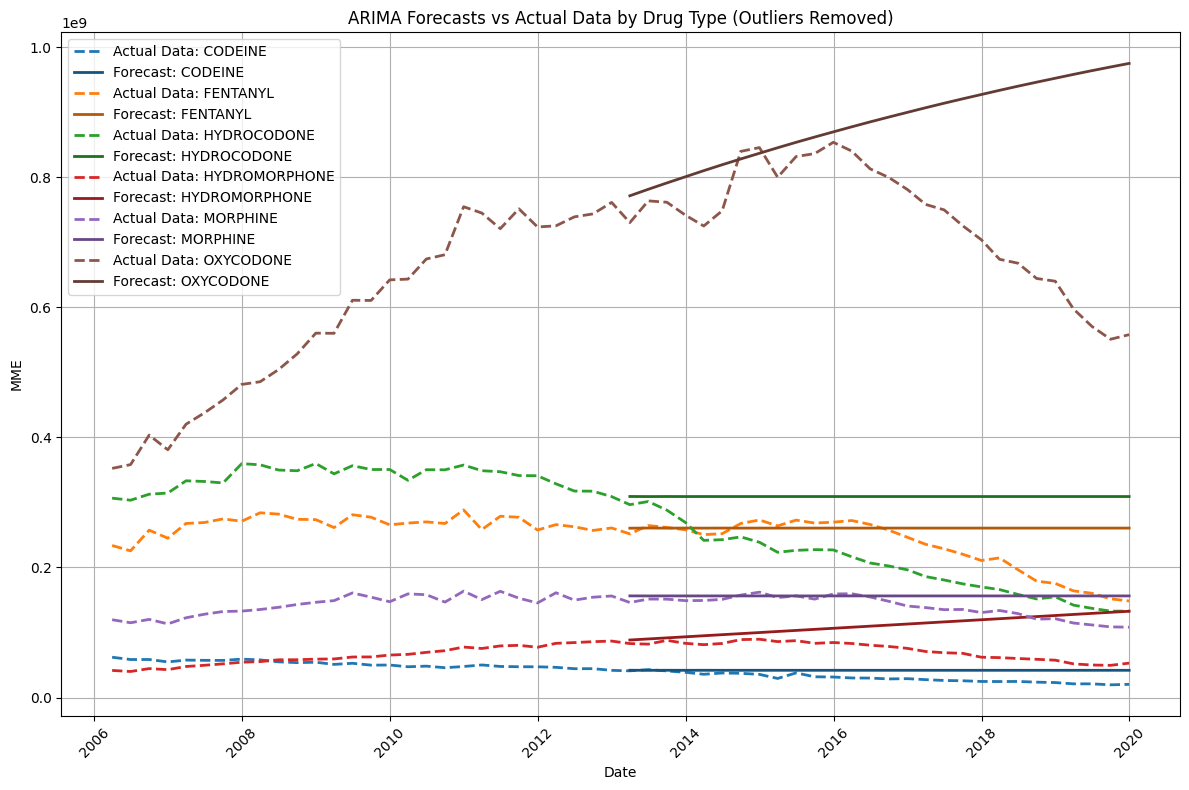

In [46]:
# WITH STATISTICS added!
from scipy import stats
import matplotlib.colors as mcolors

# Same outlier filter as before
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['MME'].quantile(0.25)
Q3 = df['MME'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['MME'] >= lower_bound) & (df['MME'] <= upper_bound)]

# Group the MME quarterly
quarterly_mme_filtered = df_filtered.groupby('drug_name').resample('QE')['MME'].sum().reset_index()

# Divide into 6 drug types
unique_drugs = quarterly_mme_filtered['drug_name'].unique()
forecast_steps = 28

# PLOTTING #############################################
plt.figure(figsize=(12, 8))  # Set up the figure size

# Define a list of dark colors for the drugs (Dark so it is visible)
dark_colors = list(mcolors.TABLEAU_COLORS.values())  # Use a predefined set of dark Tableau colors

# Function to adjust color brightness (lighten or darken)
def adjust_color_brightness(color, factor=0.8):
    """
    Adjust the brightness of a color. 
    factor < 1 will darken the color, factor > 1 will lighten it.
    """
    rgb = mcolors.hex2color(color)  # Convert hex to RGB
    rgb = [max(min(c * factor, 1), 0) for c in rgb]  # Apply the brightness factor
    return mcolors.rgb2hex(rgb)  # Convert back to hex

# Loop through each drug for both the actual data and forecast (I want to graph both)
for i, drug in enumerate(unique_drugs):
    # Filter the data to get the current drug
    drug_data = quarterly_mme_filtered[quarterly_mme_filtered['drug_name'] == drug]

    # IF the data is empty, just continue
    if drug_data.empty:
        print(f"No data available for {drug}.")
        continue

    # Fit the ARIMA model
    train_data = drug_data['MME'][:int(len(drug_data) * 0.50)]
    model = ARIMA(train_data, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast into the future...
    arima_forecast = model_fit.forecast(steps=forecast_steps)

    # Make a new index with the forecasted value
    last_date = drug_data['transaction_date'].iloc[int(len(train_data)) - 1]  # Last date of training data
    future_index = pd.date_range(start=last_date + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='QE')

    # Get the color from earlier (
    base_color = dark_colors[i % len(dark_colors)]  # Ensure that colors cycle through the palette

    # Adjust the brightness of the forecast (slightly lighter/darker)
    forecast_color = adjust_color_brightness(base_color, factor=0.7)  # Darken for forecast

    # Plot the actual data (with thicker lines)
    plt.plot(drug_data['transaction_date'], drug_data['MME'], label=f'Actual Data: {drug}', linestyle='--', color=base_color, linewidth=2)

    # Plot the forecast (with thicker lines)
    plt.plot(future_index, arima_forecast, label=f'Forecast: {drug}', linestyle='-', color=forecast_color, linewidth=2)

    # Calculate errors
    # Align actual values with forecasted values
    actual_values = drug_data['MME'].iloc[-forecast_steps:].values  # Actual values for the forecast period
    forecast_values = arima_forecast[:len(actual_values)]  # Corresponding forecast values

    # Calculate error metrics if there are actual values
    if len(actual_values) == len(forecast_values):
        mae = np.mean(np.abs(actual_values - forecast_values))
        mse = np.mean((actual_values - forecast_values) ** 2)
        rmse = np.sqrt(mse)

        print(f'{drug} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')

        # Perform a t-test on the residuals
        residuals = actual_values - forecast_values
        t_stat, p_value = stats.ttest_1samp(residuals, 0)

        print(f'{drug} - t-statistic: {t_stat:.2f}, p-value: {p_value:.5f}')
        if p_value < 0.05:
            print(f'The mean difference for {drug} is statistically significant (p < 0.05).')
        else:
            print(f'The mean difference for {drug} is not statistically significant (p >= 0.05).')


# Formatting the plot
plt.title('ARIMA Forecasts vs Actual Data by Drug Type (Outliers Removed)')
plt.xlabel('Date')
plt.ylabel('MME')
plt.legend(loc='upper left')  # Adjust legend position
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ensure everything fits well
plt.show()

CODEINE - MAE: 7567049.23, MSE: 78467970127503.66, RMSE: 8858214.84
CODEINE - t-statistic: 8.33, p-value: 0.00000
The mean difference for CODEINE is statistically significant (p < 0.05).
FENTANYL - MAE: 25474566.73, MSE: 823041223445678.00, RMSE: 28688695.05
FENTANYL - t-statistic: 2.24, p-value: 0.03370
The mean difference for FENTANYL is statistically significant (p < 0.05).
HYDROCODONE - MAE: 22777900.64, MSE: 764698274901183.62, RMSE: 27653178.39
HYDROCODONE - t-statistic: 4.80, p-value: 0.00005
The mean difference for HYDROCODONE is statistically significant (p < 0.05).


/afs/crc.nd.edu/user/c/chealy5/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/afs/crc.nd.edu/user/c/chealy5/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/afs/crc.nd.edu/user/c/chealy5/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/afs/crc.nd.edu/user/c/chealy5/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarni

HYDROMORPHONE - MAE: 44770670.97, MSE: 2862677976935914.50, RMSE: 53503999.63
HYDROMORPHONE - t-statistic: -7.94, p-value: 0.00000
The mean difference for HYDROMORPHONE is statistically significant (p < 0.05).
MORPHINE - MAE: 77908338.58, MSE: 8522227535419487.00, RMSE: 92315911.60
MORPHINE - t-statistic: -8.17, p-value: 0.00000
The mean difference for MORPHINE is statistically significant (p < 0.05).
OXYCODONE - MAE: 240194649.66, MSE: 100154295242760672.00, RMSE: 316471634.18
OXYCODONE - t-statistic: -6.06, p-value: 0.00000
The mean difference for OXYCODONE is statistically significant (p < 0.05).


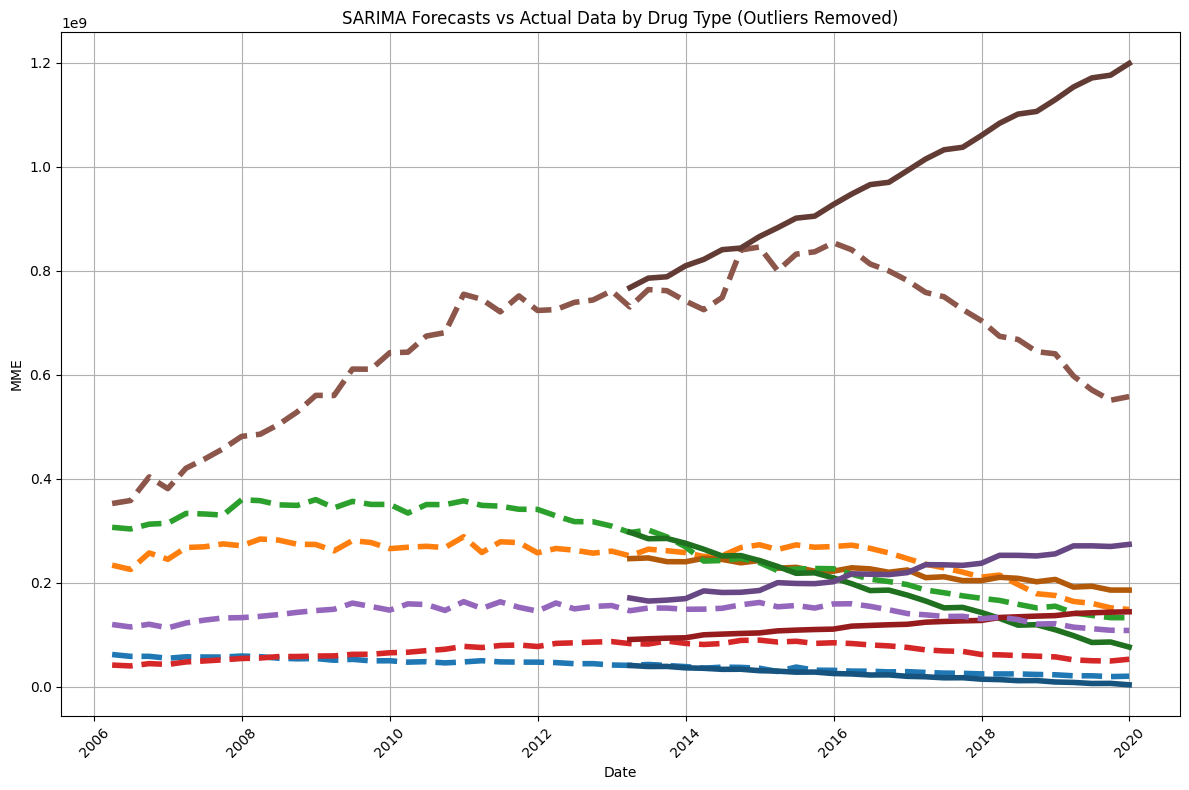

In [49]:
# ATTEMPT SEASONALITY
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# AGAIN, THE SAME EXACT OUTLIER STUFF
Q1 = df['MME'].quantile(0.25)
Q3 = df['MME'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['MME'] >= lower_bound) & (df['MME'] <= upper_bound)]

# Resample for QUARTERLY MME
quarterly_mme_filtered = df_filtered.groupby('drug_name').resample('QE')['MME'].sum().reset_index()

# Separate by drug type
unique_drugs = quarterly_mme_filtered['drug_name'].unique()
forecast_steps = 28

#  PLOTTING SECTION
plt.figure(figsize=(12, 8)) 

# Define a list of dark colors for the drugs
dark_colors = list(mcolors.TABLEAU_COLORS.values())  # Use a predefined set of dark Tableau colors

# FUNCITON TO GET DARK COLORS
def adjust_color_brightness(color, factor=0.8):
    """
    Adjust the brightness of a color. 
    factor < 1 will darken the color, factor > 1 will lighten it.
    """
    rgb = mcolors.hex2color(color)  # Convert hex to RGB
    rgb = [max(min(c * factor, 1), 0) for c in rgb]  # Apply the brightness factor
    return mcolors.rgb2hex(rgb)  # Convert back to hex

# Loop through each drug for both actual data and forecast
for i, drug in enumerate(unique_drugs):
    # gfilter out the data
    drug_data = quarterly_mme_filtered[quarterly_mme_filtered['drug_name'] == drug]

    if drug_data.empty:
        print(f"No data available for {drug}.") # IF EMPTY, SKIP
        continue

    # Fit the SARIMA model (seasonal ARIMA)
    train_data = drug_data['MME'][:int(len(drug_data) * 0.50)]
    model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))  # SARIMA with s=4 for quarterly data
    model_fit = model.fit(disp=False)

    # forecast into the future
    arima_forecast = model_fit.forecast(steps=forecast_steps)

    # make new indices
    last_date = drug_data['transaction_date'].iloc[int(len(train_data)) - 1]  # Last date of training data
    future_index = pd.date_range(start=last_date + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='QE')

    # Pick a dark color from list (see above)
    base_color = dark_colors[i % len(dark_colors)]  

    # Adjust the brightness of the forecast (slightly lighter/darker)
    forecast_color = adjust_color_brightness(base_color, factor=0.7)  # We will Darken for forecast

    # Plot the actual data (with thicker lines)
    plt.plot(drug_data['transaction_date'], drug_data['MME'], label=f'Actual Data: {drug}', linestyle='--', color=base_color, linewidth=4)

    # Plot the forecast (with thicker lines)
    plt.plot(future_index, arima_forecast, label=f'Forecast: {drug}', linestyle='-', color=forecast_color, linewidth=4)


    # Calculate errors
    # Align actual values with forecasted values
    actual_values = drug_data['MME'].iloc[-forecast_steps:].values  # Actual values for the forecast period
    forecast_values = arima_forecast[:len(actual_values)]  # Corresponding forecast values

    # Calculate error metrics if there are actual values
    if len(actual_values) == len(forecast_values):
        mae = np.mean(np.abs(actual_values - forecast_values))
        mse = np.mean((actual_values - forecast_values) ** 2)
        rmse = np.sqrt(mse)

        print(f'{drug} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')

        # Perform a t-test on the residuals
        residuals = actual_values - forecast_values
        t_stat, p_value = stats.ttest_1samp(residuals, 0)

        print(f'{drug} - t-statistic: {t_stat:.2f}, p-value: {p_value:.5f}')
        if p_value < 0.05:
            print(f'The mean difference for {drug} is statistically significant (p < 0.05).')
        else:
            print(f'The mean difference for {drug} is not statistically significant (p >= 0.05).')


# Formatting the plot
plt.title('SARIMA Forecasts vs Actual Data by Drug Type (Outliers Removed)')
plt.xlabel('Date')
plt.ylabel('MME')
#plt.legend(loc='upper left')  # Adjust legend position
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ensure everything fits well
plt.show()